In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, classification_report

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
import catboost as cb
import xgboost as xgb

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



Bad key "text.kerning_factor" on line 4 in
C:\Users\Hannah\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\Hannah\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Hannah\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"Catboost": cb.CatBoostClassifier()})
classifiers.update({"XGB": xgb.XGBClassifier(objective="binary:logistic", random_state=42)})

In [3]:
# Initiate parameter grid
parameters = {}

# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier()],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.5]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier()],
                                "classifier__n_estimators": [200],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.05], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [5],
                                        "classifier__min_samples_split": [0.05],
                                        "classifier__min_samples_leaf": [0.05],
                                        "classifier__max_features": ["log2"],
                                        "classifier__subsample": [0.8]
                                         }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": ["balanced"],
                                    "classifier__max_features": ["auto"],
                                    "classifier__max_depth" : [6],
                                    "classifier__min_samples_split": [0.005],
                                    "classifier__min_samples_leaf": [0.005],
                                    "classifier__criterion" :["entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})


# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": [29],
                            "classifier__p": [1],
                            "classifier__leaf_size": [5],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [ (10,10,10)],
                            "classifier__activation": ["relu"],
                            "classifier__learning_rate": ["invscaling"],
                            "classifier__max_iter": [200],
                            "classifier__alpha": [1e-06],
                             }})



parameters.update({"NuSVC": { 
                            "classifier__nu": [0.50],
                            "classifier__kernel": ["rbf"],
                            "classifier__degree": [1],
                             }})

# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :[ "entropy"],
                            "classifier__splitter": ["best"],
                            "classifier__class_weight": [None],
                            "classifier__max_features": ["auto"],
                            "classifier__max_depth" : [7],
                            "classifier__min_samples_split": [0.005],
                            "classifier__min_samples_leaf": [0.01],
                             }})


parameters.update({"Catboost": {
                            'classifier__depth': [10],
                            'classifier__iterations': [300],
                            'classifier__l2_leaf_reg': [9],
                            'classifier__learning_rate': [0.03]}})

parameters.update({"XGB": {
                            'classifier__colsample_bytree': [0.8],
                             'classifier__gamma': [0.1],
                             'classifier__max_depth': [5],
                             'classifier__min_child_weight': [1],
                             'classifier__reg_alpha': [0.01],
                             'classifier__subsample': [0.8]}})

In [4]:
df = pd.read_csv("promisin_couples.csv")
#df.replace(to_replace = -1 , value =np.nan)

X = df.iloc[:, 1:138].values
y = df.iloc[:, 139].values

#imputing missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer()
#imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imputer.fit(X[:, 1:138])
X[:, 1:138] = imputer.transform(X[:, 1:138])

#Making all the values discrete
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X = est.fit_transform(X)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:163: UserWarning: Feature 125 is constant and will be replaced with 0.
  "replaced with 0." % jj)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:163: UserWarning: Feature 131 is constant and will be replaced with 0.
  "replaced with 0." % jj)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:163: UserWarning: Feature 132 is constant and will be replaced with 0.
  "replaced with 0." % jj)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:163: UserWarning: Feature 133 is constant and will be replaced with 0.
  "replaced with 0." % jj)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:163: UserWarning: Feature 134 is constant and will be replaced with 0.
  "replaced with 0." % jj)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:

In [5]:
#chi square based feauture selection
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(f_classif, k=20)
X = selector.fit_transform(X, y)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [125 131 132 133 134 135] are constant.
  UserWarning)
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)

In [7]:


###############################################################################
#                       13. Classifier Training and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
results = pd.DataFrame(columns = ["Classifiers", "Best Parameters"
              "Training AUC",
              "Test AUC",
              "Accuracy",
              "F-Measure",
               "Report"                   
                        ])

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 10,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))  
    clf = gscv.best_estimator_
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    
    result_table = result_table.append({'classifiers':classifier_label,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    #report = classification_report(y_test, y_pred)
    
    # Save results
    results = results.append({"Classifier": classifier_label,
              "Best Parameters": gscv.best_params_,
              "Training AUC": gscv.best_score_,
              "Test AUC": auc,
              "Accuracy": accuracy_score(y_test, y_pred),
              "F-Measure": f1_score(y_test, y_pred, average = 'weighted'),
              "Report": classification_report(y_test, y_pred, digits=3)
                             }, ignore_index = True)



Now tuning AdaBoost.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Now tuning Bagging.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s finished


Now tuning Gradient Boosting.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished


Now tuning Random Forest.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


Now tuning KNN.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


Now tuning MLP.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.5s finished
C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Now tuning NuSVC.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


Now tuning DTC.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Now tuning Catboost.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished


0:	learn: 0.6700640	total: 743ms	remaining: 3m 42s
1:	learn: 0.6470936	total: 926ms	remaining: 2m 18s
2:	learn: 0.6279066	total: 1.07s	remaining: 1m 46s
3:	learn: 0.6061508	total: 1.47s	remaining: 1m 48s
4:	learn: 0.5955905	total: 1.5s	remaining: 1m 28s
5:	learn: 0.5832021	total: 1.79s	remaining: 1m 27s
6:	learn: 0.5713157	total: 1.84s	remaining: 1m 17s
7:	learn: 0.5539016	total: 2.08s	remaining: 1m 15s
8:	learn: 0.5422822	total: 2.29s	remaining: 1m 14s
9:	learn: 0.5331627	total: 2.33s	remaining: 1m 7s
10:	learn: 0.5215995	total: 2.55s	remaining: 1m 7s
11:	learn: 0.5109889	total: 2.6s	remaining: 1m 2s
12:	learn: 0.5022317	total: 2.83s	remaining: 1m 2s
13:	learn: 0.4961146	total: 2.88s	remaining: 58.8s
14:	learn: 0.4912204	total: 3s	remaining: 57s
15:	learn: 0.4840772	total: 3.1s	remaining: 55.1s
16:	learn: 0.4724978	total: 3.29s	remaining: 54.7s
17:	learn: 0.4639309	total: 3.55s	remaining: 55.6s
18:	learn: 0.4601786	total: 3.59s	remaining: 53.1s
19:	learn: 0.4537817	total: 3.82s	remain

164:	learn: 0.3046307	total: 17.4s	remaining: 14.3s
165:	learn: 0.3044094	total: 17.5s	remaining: 14.1s
166:	learn: 0.3044023	total: 17.5s	remaining: 13.9s
167:	learn: 0.3042184	total: 17.6s	remaining: 13.8s
168:	learn: 0.3039691	total: 17.6s	remaining: 13.6s
169:	learn: 0.3037124	total: 17.6s	remaining: 13.5s
170:	learn: 0.3035750	total: 17.7s	remaining: 13.3s
171:	learn: 0.3035050	total: 17.7s	remaining: 13.2s
172:	learn: 0.3034511	total: 17.8s	remaining: 13s
173:	learn: 0.3032905	total: 17.8s	remaining: 12.9s
174:	learn: 0.3028893	total: 17.9s	remaining: 12.8s
175:	learn: 0.3028657	total: 18s	remaining: 12.6s
176:	learn: 0.3027140	total: 18s	remaining: 12.5s
177:	learn: 0.3026918	total: 18s	remaining: 12.4s
178:	learn: 0.3021752	total: 18.3s	remaining: 12.3s
179:	learn: 0.3020305	total: 18.3s	remaining: 12.2s
180:	learn: 0.3019773	total: 18.4s	remaining: 12.1s
181:	learn: 0.3017428	total: 18.4s	remaining: 11.9s
182:	learn: 0.3017283	total: 18.5s	remaining: 11.8s
183:	learn: 0.301584

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.5s finished


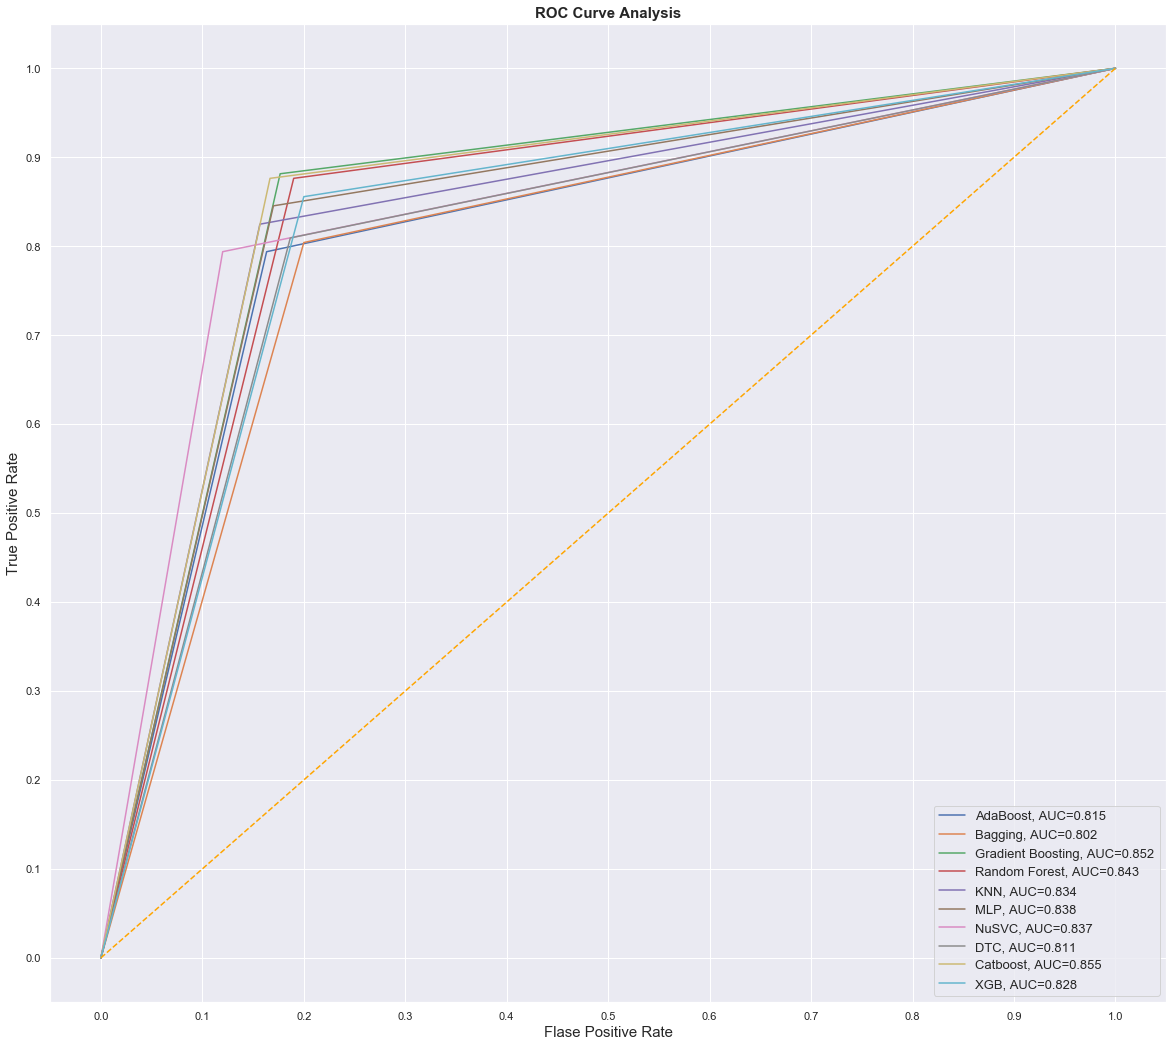

In [8]:
#generating curve
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')



# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(20,18))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()
fig.savefig('multiple_roc_curve(f_classif(20))final.png')

In [9]:
results.to_csv('Accuracy(f_classif(20))final.csv')